In [1]:
import pandas as pd
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
#combine above and this
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from scipy.stats import kendalltau

In [5]:
#delete this after and replace with reviews.csv
!git clone https://github.com/dregmi08/Milestone-2-Data-Exploration-Initial-Preprocessing.git



Cloning into 'Milestone-2-Data-Exploration-Initial-Preprocessing'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 93 (delta 42), reused 35 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (93/93), 44.40 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (42/42), done.


## Preprocessing and generating Word2Vec

In [77]:
#df = pd.read_csv("reviews.csv")
df = pd.read_csv('Milestone-2-Data-Exploration-Initial-Preprocessing/reviews.csv')

In [78]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [79]:
def clean_text(text):
    tokens = word_tokenize(text)
    lower = [token.lower() for token in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lower]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    words = [porter.stem(word) for word in words]
    non_stop_words = [w for w in words if not w in stop_words]
    return " ".join(non_stop_words)

In [80]:
df["Review_cleaned"] = df["Review"].apply(clean_text)

In [81]:
def categorize_rating(rating):
    if rating < 3:
        return "NEGATIVE"
    else:
        return "POSITIVE"

In [82]:
df["Rating_category"] = df["Rating"].apply(categorize_rating)

In [83]:
tokenized_reviews = [review.split() for review in df["Review_cleaned"]]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

In [84]:
def get_average_word2vec(review, model):
    words = review.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

df['vector'] = df['Review_cleaned'].apply(lambda x: get_average_word2vec(x, word2vec_model))

## Fitting and Evaluating Model

In [85]:
X = np.vstack(df['vector'].values)
y = df['Rating_category'].values

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [87]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [88]:
y_pred = clf.predict(X_test)
print('Results on test set')
print(classification_report(y_test, y_pred))
y_pred_train = clf.predict(X_train)
print('Results on training set')
print(classification_report(y_train, y_pred_train))

Results on test set
              precision    recall  f1-score   support

    NEGATIVE       0.74      0.80      0.77      4884
    POSITIVE       0.86      0.82      0.84      7435

    accuracy                           0.81     12319
   macro avg       0.80      0.81      0.81     12319
weighted avg       0.81      0.81      0.81     12319

Results on training set
              precision    recall  f1-score   support

    NEGATIVE       0.75      0.80      0.78     19887
    POSITIVE       0.86      0.82      0.84     29388

    accuracy                           0.81     49275
   macro avg       0.81      0.81      0.81     49275
weighted avg       0.82      0.81      0.82     49275



In [89]:
df['Predicted_sentiment'] = clf.predict(np.vstack(df['vector'].values))

In [90]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply,Review_cleaned,Rating_category,vector,Predicted_sentiment
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN,great music servic audio high qualiti app easi...,POSITIVE,"[-0.30376986, 0.6236368, 0.53673273, 0.0650941...",POSITIVE
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN,pleas ignor previou neg rate thi app super gre...,POSITIVE,"[-0.16027461, -0.27733007, -0.6428071, -0.0636...",POSITIVE
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN,thi popup get best spotifi experi android anno...,POSITIVE,"[-0.2718488, 0.07895216, -0.06766935, -0.74427...",NEGATIVE
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN,realli buggi terribl use recent,NEGATIVE,"[-0.42100468, 0.39464593, -0.12235167, -0.2715...",NEGATIVE
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN,dear spotifi whi get song nt put playlist whi ...,NEGATIVE,"[-0.059314705, 0.6072901, -0.19776769, -1.0190...",NEGATIVE


## Plotting Learning Curve

In [91]:
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, cv=5, scoring='accuracy')
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std = valid_scores.std(axis=1)

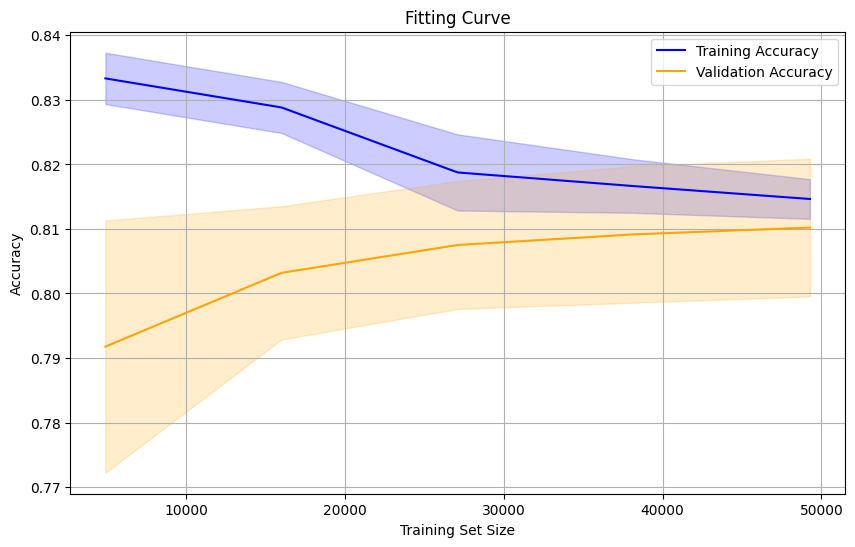

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

plt.plot(train_sizes, valid_mean, label="Validation Accuracy", color="orange")
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color="orange")

plt.title("Fitting Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

##Part 2: Feature Ranking

In [93]:
df = df[['Review_cleaned', 'Predicted_sentiment', 'Rating']]
df

,Review_cleaned,Predicted_sentiment,Rating
0,great music servic audio high qualiti app easi...,POSITIVE,5
1,pleas ignor previou neg rate thi app super gre...,POSITIVE,5
2,thi popup get best spotifi experi android anno...,NEGATIVE,4
3,realli buggi terribl use recent,NEGATIVE,1
4,dear spotifi whi get song nt put playlist whi ...,NEGATIVE,1
...,...,...,...
61589,even though wa commun lyric featur avail user ...,POSITIVE,1
61590,use sooo good back download free version could...,POSITIVE,1
61591,thi app would good take ani devic start comp s...,POSITIVE,2
61592,app good hard navig wo nt let play song click ...,NEGATIVE,2


In [94]:
#Prepare reviews for LDA model
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['Review_cleaned'])

#LDA model
lda_mod = LatentDirichletAllocation(n_components=20, random_state=0)
lda_mod.fit(X)
topics = lda_mod.transform(X)

In [95]:
#Generate topics of features present in ratings

features = vectorizer.get_feature_names_out()


topic_df = pd.DataFrame({
    f"Topic {topic_idx + 1}": [
        features[i] for i in topic.argsort()[-10:]
    ]
    for topic_idx, topic in enumerate(lda_mod.components_)
})


print("Most common features per topic:")
print(topic_df)

Most common features per topic:
    Topic 1     Topic 2        Topic 3     Topic 4      Topic 5   Topic 6  \
0      issu      search          remov  app listen          get      issu   
1      even  everi song          pleas     use thi      nt even       thi   
2       app      listen  song playlist         use  pay premium  reinstal   
3   problem          ad          album       music      without  uninstal   
4      show   great app            one    love thi         even        ha   
5   spotifi       lyric         option      listen          pay   spotifi   
6  internet         app           make        love      premium       use   
7       thi       great           song     thi app        ca nt     phone   
8   connect       everi            add         app           ca       app   
9   podcast        song       playlist         thi           nt      work   

      Topic 7    Topic 8    Topic 9      Topic 10     Topic 11  Topic 12  \
0    best app       issu     realli         

In [96]:
#Rank Topics by sentiment of reviews, negative to positive
def get_sentiment_score(rating):
    if rating == 'POSITIVE':
        return 1
    elif rating == 'NEGATIVE':
        return -1
    else:
        return 0

df['sentiment_score'] = df['Predicted_sentiment'].apply(get_sentiment_score)

topic_sentiment_scores = np.dot(topics.T, df['sentiment_score'])

topic_score_df = pd.DataFrame({
    'topic': [f'Topic {i+1}' for i in range(len(topic_sentiment_scores))],
    'sentiment_score': topic_sentiment_scores,
})

sentiment_ranked = topic_score_df.sort_values(by='sentiment_score', ascending=True)

print("Topics:")
print(sentiment_ranked)

Topics:
       topic  sentiment_score
11  Topic 12     -2734.547912
16  Topic 17     -1422.759498
7    Topic 8     -1004.238353
18  Topic 19      -836.071063
14  Topic 15      -791.347294
19  Topic 20      -773.150368
4    Topic 5      -728.121907
5    Topic 6      -711.083272
0    Topic 1      -431.801975
15  Topic 16       284.904730
13  Topic 14       338.595855
17  Topic 18       568.657128
2    Topic 3       756.180079
1    Topic 2      1334.966845
3    Topic 4      1522.156000
10  Topic 11      1761.774865
8    Topic 9      2371.687651
9   Topic 10      2705.606685
6    Topic 7      2796.170586
12  Topic 13      3818.421219


In [97]:
#To test accuracy of ranked features: This code classifies reviews into predefined sentiment topics (below) with frequency

# Manually assign labels for the topics (only for all negative topics)
topic_labels = {
    'Topic 13': "Issues with music pausing/suddenly stopping",
    'Topic 3': "Login Issues",
    'Topic 8': "Issues with playlist and shuffle",
    'Topic 4': "Issues with playing music when closing app",
    'Topic 19': "Issues when connecting to different devices/platforms",
    'Topic 1': "App Crashes and Stability Problems",
    'Topic 18': "Connectivity and Podcast Issues",
    'Topic 7': "Ads and Ad-Free Experience",
    'Topic 11': "Playlist and Download Management",
    'Topic 6': "Free vs Premium App Experience",
}


candidate_labels = [
    'Issues with music pausing/suddenly stopping',
    'Login Issues',
    'Issues with playlist and shuffle',
    'Issues with playing music when closing app',
    'Issues when connecting to different devices/platforms',
    'App Crashes and Stability Problems',
    'Connectivity and Podcast Issues',
    'Ads and Ad-Free Experience',
    'Playlist and Download Management',
    'Free vs Premium App Experience',
]



model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
negative_reviews_subset = df[df['Rating'].isin([1, 2])]['Review_cleaned'].sample(n=24000, random_state=42).tolist()

def classify_reviews_batch(reviews, candidate_labels, model, batch_size=32):
    label_embeddings = model.encode(candidate_labels, convert_to_tensor=True)
    all_classified_reviews = []

    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        review_embeddings = model.encode(batch_reviews, convert_to_tensor=True)
        cosine_similarities = util.pytorch_cos_sim(review_embeddings, label_embeddings)

        for j, review in enumerate(batch_reviews):
            similarities = cosine_similarities[j]
            max_sim_idx = similarities.argmax()
            predicted_label = candidate_labels[max_sim_idx]
            score = similarities[max_sim_idx].item()

            all_classified_reviews.append({
                'Review': review,
                'Predicted Label': predicted_label,
                'Score': score
            })

    return all_classified_reviews

classified_reviews = classify_reviews_batch(negative_reviews_subset, candidate_labels, model)
classified_reviews_df = pd.DataFrame(classified_reviews)
label_counts = classified_reviews_df['Predicted Label'].value_counts()

print(label_counts)

Predicted Label
Issues with playing music when closing app               7826
Playlist and Download Management                         3889
App Crashes and Stability Problems                       3655
Issues with music pausing/suddenly stopping              2024
Connectivity and Podcast Issues                          1692
Ads and Ad-Free Experience                               1561
Free vs Premium App Experience                           1223
Login Issues                                             1005
Issues with playlist and shuffle                          754
Issues when connecting to different devices/platforms     371
Name: count, dtype: int64


In [98]:
#Use Kendall's Tau metric to test accuracy of ranked topics
predicted_order = [
    'Topic 13', 'Topic 3', 'Topic 8', 'Topic 4', 'Topic 19',
    'Topic 1', 'Topic 18', 'Topic 7', 'Topic 11', 'Topic 6'
]

ground_truth_order = [
    'Topic 4', 'Topic 1', 'Topic 11', 'Topic 13', 'Topic 7', 'Topic 18',
    'Topic 8', 'Topic 3', 'Topic 6', 'Topic 19'
]


predicted_ranks = [predicted_order.index(topic) for topic in ground_truth_order]
ground_truth_ranks = list(range(len(ground_truth_order)))
kendall_corr, _ = kendalltau(predicted_ranks, ground_truth_ranks)
print(f"Kendall's Tau: {kendall_corr:.4f}")

Kendall's Tau: 0.0222
